Besides using already collected data from actual microscopes, we can also simulate microscopy images using ab-initio python packages. For STEM, one good such package is ABTEM.
Here, we are going to use ABTEM to simulate STEM datasets and register them to our DTMicroscope servers.

**Imports**

In [ ]:
!pip install pyro5
!pip install scifireaders
!pip install sidpy
!pip install pynsid
!pip install git+https://github.com/pycroscopy/DTMicroscope.git
!pip install abtem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: da

In [ ]:
!run_server_stem

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Server started and running in the background. Logs are being written to server.log.


In [3]:
import abtem
import ase

If you have GPU available this makes it faster

In [4]:
abtem.config.set({"device":"gpu"})

Setting up and runnning the abtem simulations - keeping it simple (and unrealistic) for now

Things to try:
- Play with the scan sampling rate if the code is taking too long/if you want something more realistic
- We can also scramble the positions of carbons a little bit to create an "amorphous" carbon surface

[########################################] | 100% Completed | 6.98 s


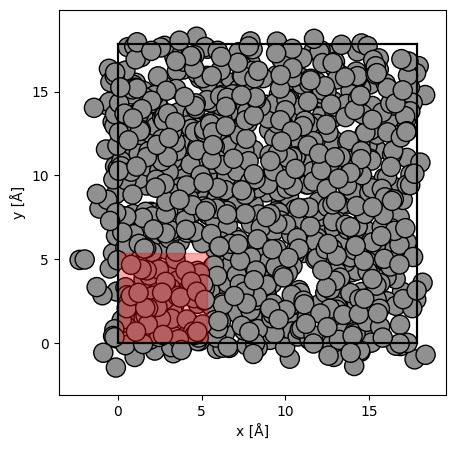

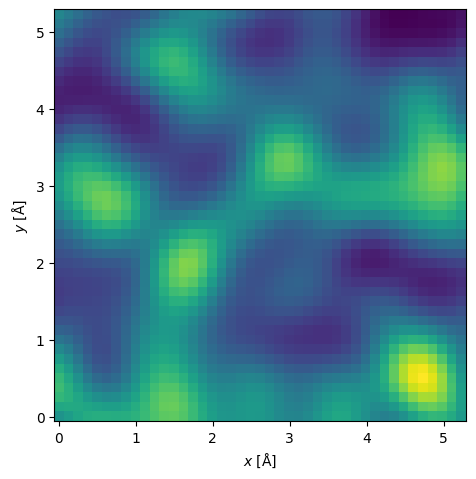

In [19]:
substrate = ase.build.bulk("C", cubic=True)
amorphous = True

# repeat diamond structure
substrate = substrate * (5,5,5)
if amorphous:
  bl = 1.54  # Bond length
  rng = np.random.default_rng(seed=10)
  substrate.positions[:] += rng.normal(size=(len(substrate), 3)) * 0.5 * bl



potential = abtem.Potential(substrate, sampling=0.05)
potential[0].compute().shape
probe = abtem.Probe(energy=60e3, semiangle_cutoff=30)
probe.grid.match(potential)
grid_scan = abtem.GridScan(
    start=(0, 0),
    end=(0.3,0.3), #0.3 is a relative size; 1 is the full substrate area
    sampling=0.125, # 0.125 A/pixel,
    fractional=True,
    potential=potential,
)
#visualize the substrate and subscan are
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
abtem.show_atoms(substrate, ax=ax)
grid_scan.add_to_plot(ax=ax)

haadf = abtem.AnnularDetector(inner=90, outer=200)

measurement = probe.scan(potential, scan=grid_scan, detectors=haadf)

measurement.compute()
measurement.show()

Converting the image into sidpy dataset, setting up necessary metadata (that I can think of), saving the sidpy dataset in an .h5 file

In [6]:
def save_dataset_dictionary(h5_file, datasets):
    h5_measurement_group = sidpy.hdf.prov_utils.create_indexed_group(h5_file, 'Measurement_')
    for key, dataset in datasets.items():
        if key[-1] == '/':
            key = key[:-1]
        if isinstance(dataset, sidpy.Dataset):
            h5_group = h5_measurement_group.create_group(key)
            h5_dataset = pyNSID.hdf_io.write_nsid_dataset(dataset, h5_group)
            dataset.h5_dataset = h5_dataset
            h5_dataset.file.flush()
        elif isinstance(dataset, dict):
            sidpy.hdf.hdf_utils.write_dict_to_h5_group(h5_measurement_group, dataset, key)
        else:
            print('could not save item ', key, 'of dataset dictionary')
    return h5_measurement_group

In [10]:
import sidpy
import h5py
import pyNSID
dataset = sidpy.Dataset.from_array(measurement.array)
dataset.quantity = 'intensity'
dataset.units = 'counts'
dataset.source = 'abtem_simulation'
dataset.modality = 'STEM data'

dataset.set_dimension(0, sidpy.Dimension(grid_scan.get_positions()[0,:,1]/10,
                                          name='x', units='nm', quantity='Distance',
                                          dimension_type='spatial'))
dataset.set_dimension(1, sidpy.Dimension(grid_scan.get_positions()[:,0,0]/10,
                                          name='y', units='nm', quantity='Distance',
                                          dimension_type='spatial'))
haadf_key = 'Channel_000'
save_dataset = {haadf_key : dataset}
dataset_name = 'test_haadf.h5'
h5_file = h5py.File(dataset_name, mode='a')
h5_item = save_dataset_dictionary(h5_file, save_dataset)
h5_file.flush()
h5_file.close()

/usr/local/lib/python3.10/dist-packages/pyNSID/io/hdf_utils.py:381: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


Registering the h5 file to STEM server and try to open it

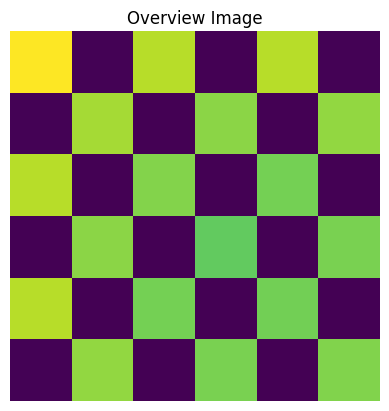

In [11]:
import matplotlib.pylab as plt
import numpy as np
import Pyro5.api
from IPython.display import clear_output, display
# Connect to the microscope server
uri = "PYRO:microscope.server@localhost:9091"
mic_server = Pyro5.api.Proxy(uri)

mic_server.initialize_microscope("STEM")
mic_server.register_data("test_haadf.h5")
# Get overview image
array_list, shape, dtype = mic_server.get_overview_image()
im_array = np.array(array_list, dtype=dtype).reshape(shape)

# Display the overview image
plt.imshow(im_array)
plt.axis("off")
plt.title("Overview Image")
plt.show()

In [20]:
spectra = []
locations = []
for x in [0,1,2]:
    for y in [0,1,2]:
        array_list, shape, dtype = mic_server.get_point_data("Channel_000", x, y)
        spectrum = np.array(array_list, dtype=dtype).reshape(shape)
        spectra.append(spectrum.flatten())  # Flatten each spectrum to make it 1D
        locations.append((x, y))

spectra = np.array(spectra)  # Convert list of spectra to a NumPy array

IndexError: Bad index.  Must be integer-like: 0.5